# Objective

This is a Loan Approval Prediction Project, where I will be using Logistic Regression as the classification model. The primary evaluation metric for this project is the F1-Score, as it provides a balance between precision and recall, which is crucial for handling class imbalance often present in loan approval datasets.

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score


In [43]:
df_raw = pd.read_csv('loan_approval_dataset.csv')

df_raw

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,4265,5,Graduate,Yes,1000000,2300000,12,317,2800000,500000,3300000,800000,Rejected
4265,4266,0,Not Graduate,Yes,3300000,11300000,20,559,4200000,2900000,11000000,1900000,Approved
4266,4267,2,Not Graduate,No,6500000,23900000,18,457,1200000,12400000,18100000,7300000,Rejected
4267,4268,1,Not Graduate,No,4100000,12800000,8,780,8200000,700000,14100000,5800000,Approved


In [44]:
df_raw.columns = df_raw.columns.str.strip()

In [45]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


This dataset is have 13 columns and 4269 rows.

In [46]:
df_raw.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [47]:
df_raw.duplicated().sum()

0

This dataset have 0 duplicates.

In [48]:
df_raw.isnull().sum()

loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

There are 0 missing values.

# Exploratory Data Analysis

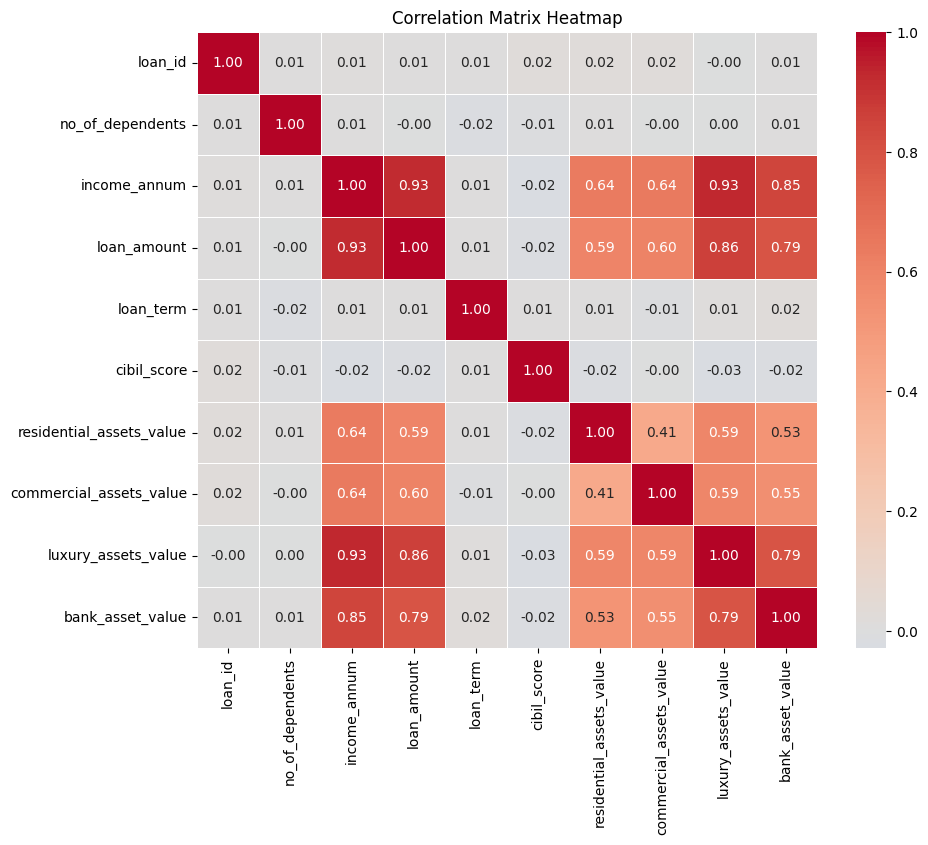

In [49]:
# Select only numeric features
numeric_features = df_raw.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_features.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [50]:
def calculate_vif(df_raw):
    num_features = df_raw.select_dtypes(include=[np.number])

    vif_data = pd.DataFrame()
    vif_data["feature"] = num_features.columns
    vif_data["VIF"] = [variance_inflation_factor(num_features.values, i) for i in range(num_features.shape[1])]
    vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)
    return vif_data

vif_result = calculate_vif(df_raw)
vif_result

,feature,VIF
0,income_annum,74.569725
1,luxury_assets_value,27.563138
2,loan_amount,27.249863
3,bank_asset_value,12.156579
4,cibil_score,6.745884
5,loan_term,4.001490
6,residential_assets_value,3.911408
7,commercial_assets_value,3.879556
8,loan_id,3.587184
9,no_of_dependents,2.882325


When calculating the Variance Inflation Factor (VIF), we observed that the features `income_annum`, `luxury_assets_value`, `loan_amount`, and `bank_asset_value` have VIF scores exceeding 10, indicating a high degree of multicollinearity. This suggests that these features carry overlapping or redundant information with other variables in the dataset.

To address this issue and improve the model's reliability, we will remove these features with high VIF scores. This step helps prevent multicollinearity from negatively impacting the model's interpretability and performance.

In [51]:
df_raw.drop(columns=['income_annum', 'luxury_assets_value', 'bank_asset_value'], inplace=True)

In [52]:
def calculate_vif(df_raw):
    num_features = df_raw.select_dtypes(include=[np.number])

    vif_data = pd.DataFrame()
    vif_data["feature"] = num_features.columns
    vif_data["VIF"] = [variance_inflation_factor(num_features.values, i) for i in range(num_features.shape[1])]
    vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)
    return vif_data

vif_result = calculate_vif(df_raw)
vif_result

,feature,VIF
0,loan_amount,7.367209
1,cibil_score,6.685143
2,loan_term,3.983288
3,commercial_assets_value,3.618501
4,residential_assets_value,3.615670
5,loan_id,3.575966
6,no_of_dependents,2.868768


After removing these features, we observed an overall improvement in the VIF scores for the remaining variables. This indicates a reduction in multicollinearity within the dataset, meaning the remaining features are now more independent from each other. By addressing multicollinearity, we enhance the model's stability, improve coefficient interpretability, and reduce the risk of misleading results.

In [53]:
#cek distribusi
fitur = list(df_raw.select_dtypes(exclude=['object', 'datetime64[ns]']).columns)

listItem= []

for col in fitur:
  listItem.append([col, round(df_raw[col].skew(),1), np.where(
    (round(df_raw[col].skew(),1) <= 0.5) & (round(df_raw[col].skew(),1) >= -0.5),
    'normal',
    'skewed')])



skewness = pd.DataFrame(columns=['column_name', 'skewness_value', 'distribution'], data= listItem)
skewness

,column_name,skewness_value,distribution
0,loan_id,0.0,normal
1,no_of_dependents,-0.0,normal
2,loan_amount,0.3,normal
3,loan_term,0.0,normal
4,cibil_score,-0.0,normal
5,residential_assets_value,1.0,skewed
6,commercial_assets_value,1.0,skewed


The overall data distribution appears to be fairly normal across most features, with the exception of  `residential_assets_value` and `commercial_assets_value`, which exhibit noticeable skewness. However, this is expected and quite common in loan approval datasets, as asset values tend to vary significantly between individuals, often resulting in a positively skewed distribution. In such cases, a small number of applicants possess high-value assets, while the majority own assets of relatively lower value.

In [54]:
# Inisialisasi list kosong
column = []
lower_bound = []
upper_bound = []
percent_total_outlier = []
outlier_count = []

# Loop setiap baris pada skewness
for row in range(len(skewness)):
    col = skewness['column_name'].iloc[row]

    # Cek distribusi: skewed atau normal
    if skewness['distribution'].iloc[row] == 'skewed':
        IQR = df_raw[col].quantile(0.75) - df_raw[col].quantile(0.25)
        lower_boundary = df_raw[col].quantile(0.25) - (IQR * 3)
        upper_boundary = df_raw[col].quantile(0.75) + (IQR * 3)
    else:
        lower_boundary = df_raw[col].mean() - 3 * df_raw[col].std()
        upper_boundary = df_raw[col].mean() + 3 * df_raw[col].std()

    # Hitung jumlah dan persentase outlier
    total_outliers = df_raw[(df_raw[col] > upper_boundary) | (df_raw[col] < lower_boundary)].shape[0]
    percent_outliers = (total_outliers / len(df_raw)) * 100

    # Simpan ke list
    column.append(col)
    lower_bound.append(lower_boundary)
    upper_bound.append(upper_boundary)
    outlier_count.append(total_outliers)
    percent_total_outlier.append(percent_outliers)

# Buat DataFrame hasil
outliers = pd.DataFrame({
    'column': column,
    'lower_boundary': [round(val, 2) for val in lower_bound],
    'upper_boundary': [round(val, 2) for val in upper_bound],
    'outlier_count': outlier_count,
    'percentage_total_outlier': [round(val, 2) for val in percent_total_outlier]
})

outliers

,column,lower_boundary,upper_boundary,outlier_count,percentage_total_outlier
0,loan_id,-1562.50,5832.50,0,0.0
1,no_of_dependents,-2.59,7.59,0,0.0
2,loan_amount,-11996638.50,42263539.41,0,0.0
3,loan_term,-6.23,28.03,0,0.0
4,cibil_score,82.64,1117.23,0,0.0
5,residential_assets_value,-25100000.00,38600000.00,0,0.0
6,commercial_assets_value,-17600000.00,26500000.00,0,0.0


In [55]:
df = df_raw.copy()

In [56]:
df.head()

,loan_id,no_of_dependents,education,self_employed,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,loan_status
0,1,2,Graduate,No,29900000,12,778,2400000,17600000,Approved
1,2,0,Not Graduate,Yes,12200000,8,417,2700000,2200000,Rejected
2,3,3,Graduate,No,29700000,20,506,7100000,4500000,Rejected
3,4,3,Graduate,No,30700000,8,467,18200000,3300000,Rejected
4,5,5,Not Graduate,Yes,24200000,20,382,12400000,8200000,Rejected


Text(0, 0, 'Total: 4269')

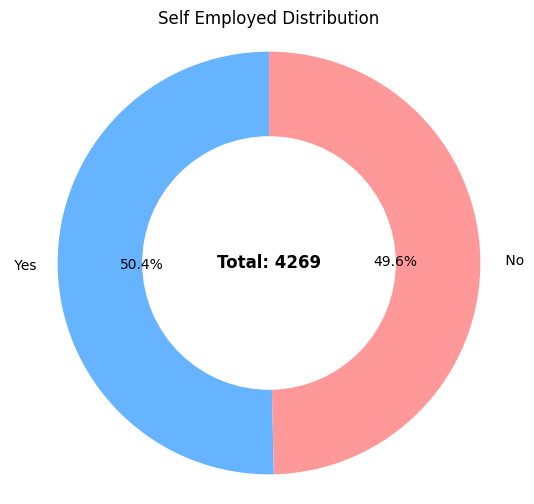

In [57]:
# Count values in the 'self_employed' column
self_employed_counts = df['self_employed'].value_counts()
labels = self_employed_counts.index
sizes = self_employed_counts.values
total = sizes.sum()

# Plot donut chart
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999'],
    wedgeprops={'width': 0.4}  # makes it a donut
)

# Equal aspect ratio ensures the pie is drawn as a circle
plt.axis('equal')
plt.title('Self Employed Distribution')

# Add total count in the center
plt.text(0, 0, f'Total: {total}', ha='center', va='center', fontsize=12, fontweight='bold')


We examined the distribution of the `self_employed`  feature and found that it is fairly balanced, with 50.4% of the applicants being self-employed and 49.6% not self-employed. This distribution is based on a total of 4,269 data points, indicating that there is no significant class imbalance for this particular feature.

Text(0, 0, 'Total: 4269')

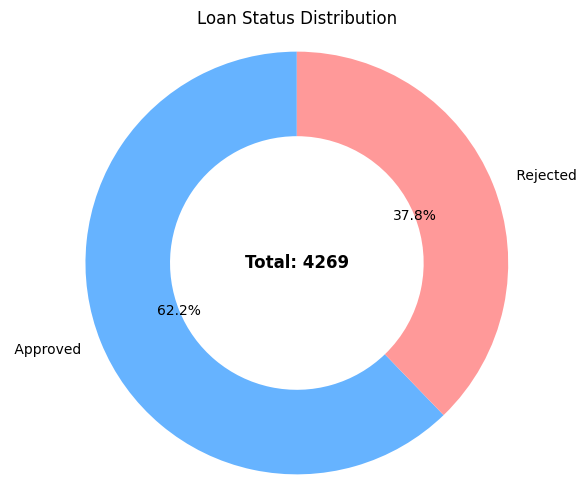

In [58]:
# Count values in the 'loan_status' column
default_counts = df_raw['loan_status'].value_counts()
labels = default_counts.index
sizes = default_counts.values
total = sizes.sum()

# Plot donut chart
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999'],
    wedgeprops={'width': 0.4}  # makes it a donut
)

# Equal aspect ratio ensures the pie is drawn as a circle
plt.axis('equal')
plt.title('Loan Status Distribution')

# Add total count in the center
plt.text(0, 0, f'Total: {total}', ha='center', va='center', fontsize=12, fontweight='bold')


We can observe that the distribution of `loan_status` is noticeably imbalanced. Out of 4269 records, 62.2% of the loan applications were Approved, while 37.8% were Rejected. This level of imbalance is quite common in loan approval datasets, as financial institutions tend to approve a higher proportion of applications, provided applicants meet the required eligibility criteria.

While this imbalance is expected, it is important to account for it during model development by selecting appropriate evaluation metrics, such as the F1-Score, to ensure reliable performance, especially for the minority class.

In [59]:
df.groupby('loan_status')['cibil_score'].mean()

loan_status
Approved    703.461973
Rejected    429.468072
Name: cibil_score, dtype: float64

The average CIBIL score for approved loan applications is 703, while for rejected applications, it is 429. The CIBIL score is one of the most commonly used credit score evaluations, especially in India, where it is provided by the Credit Information Bureau (India) Limited (CIBIL). In general, a higher credit score indicates better creditworthiness, while a lower score suggests higher risk for lenders.

<Axes: xlabel='loan_status', ylabel='cibil_score'>

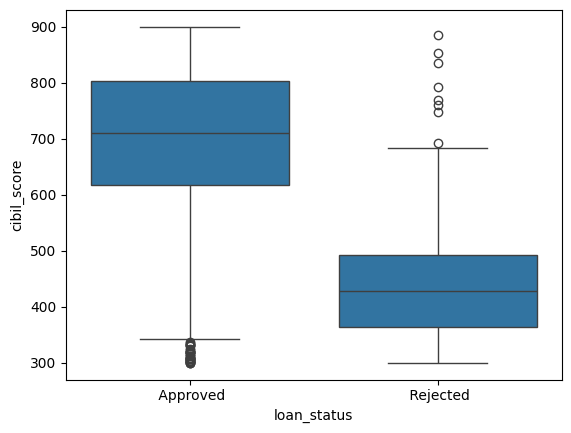

In [60]:
# Boxplot for cibil score by loan status
sns.boxplot(x='loan_status', y='cibil_score', data=df)

We saw earlier that the average CIBIL score for approved applications is 703, while for rejected applications, it is 429. However, when we look at the boxplot, it reveals more details about the distribution beyond just the averages.

Interestingly, the boxplot shows that some applicants with CIBIL score as low as 300 still had their loan approved. This suggest that while credit score plays a significant role, it is not the sole factor determining loan approval. Other factors such as `loan_amount`, `loan_terms` and assets might have influenced the decision.

On the other hand, we also observe that there are applicants with CIBIL scores higher than 700 who still faced rejection. These high scores are present in the rejected group as outliers, reinforcing the idea that a high credit score does not guarantee approval if other eligibility criteria are not met.

This highlights the importance of considering the full applicant profile, rather than relying solely on the credit score when evaluating loan applications.

Text(0.5, 1.0, 'Loan Status by Self Employed')

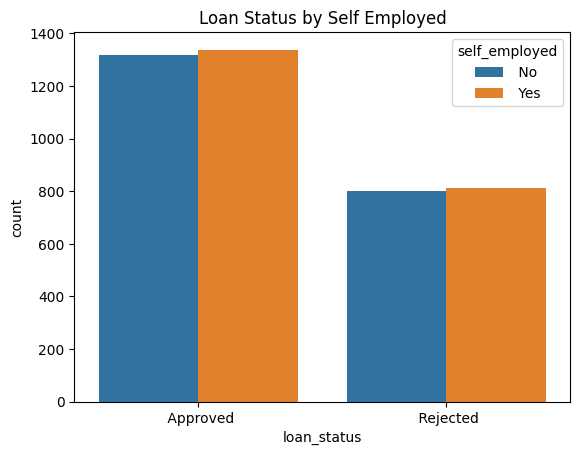

In [61]:
sns.countplot(x='loan_status', hue='self_employed', data=df)
plt.title('Loan Status by Self Employed')

we could see that the difference between `self_employed` and `loan_status` is relatively minor. This indicates that being self-employed is not a decisive factor in whether a loan is approved or rejected.

While employment type might influence loan decisions to some extent, the data suggests that lenders likely consider a combination of factors such as income stability, credit score, existing liabilities, and asset ownership, rather than relying solely on employment type.

In other words, both self-employed and salaried applicants have comparable chances of loan approval, provided they meet the other key eligibility criteria. This insight aligns with real-world lending practices, where a holistic evaluation of the applicant's financial profile is conducted, rather than decisions being made based on a single attribute.

<Axes: xlabel='loan_status', ylabel='loan_amount'>

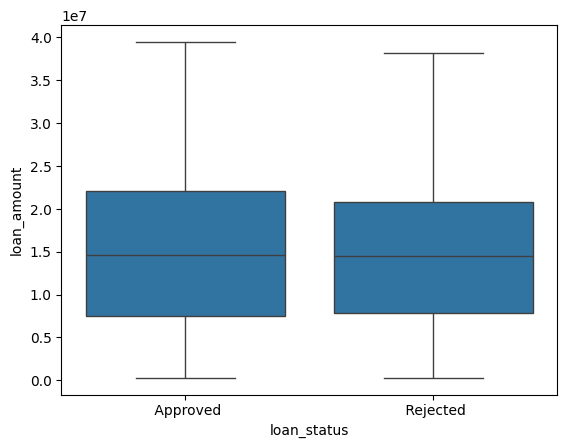

In [62]:
sns.boxplot(x='loan_status', y='loan_amount', data=df)

`loan_amount` does not appear to have a clear or significant impact on `loan_status` decisions based on this visualization. The distribution of loan amounts is fairly similar between approved and rejected applications, with both groups showing a wide range of loan amounts and comparable median values. This suggests that the loan amount alone is not a key determining factor for approval or rejection.

<Axes: xlabel='loan_status', ylabel='loan_term'>

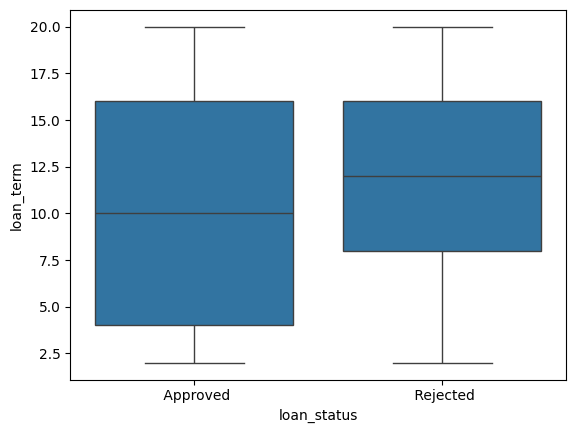

In [63]:
sns.boxplot(x='loan_status', y='loan_term', data=df)

Based on the boxplot for `loan_term` and `loan_status`, we can observe that the lower bound of the loan term for rejected applications is higher, at approximately 8 months, compared to the approved applications, where the lower bound is around 4 months. This suggests that applicants requesting shorter loan terms are more likely to receive approval, whereas those applying for longer minimum loan terms may face a higher risk of rejection.

# Feature Engineering

In [64]:
pd.set_option('display.max_colwidth', None)

cat_cols = list(df_raw.select_dtypes(include='object').columns)

listItem = []
for col in cat_cols:
  listItem.append([col, df_raw[col].nunique(), df_raw[col].unique()])

pd.DataFrame(columns=['column_name', 'unique_value_counts', 'unique_value'], data=listItem)

,column_name,unique_value_counts,unique_value
0,education,2,"[ Graduate, Not Graduate]"
1,self_employed,2,"[ No, Yes]"
2,loan_status,2,"[ Approved, Rejected]"


We conducted a cardinality check on the dataset. The features `education`, `self_employed`, and `loan_status` each have 2 unique values, confirming that they are binary categorical variables.

# Splitting

In [65]:
X = df.drop(columns=['loan_status', 'loan_id'])
y = df['loan_status']

X

,no_of_dependents,education,self_employed,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value
0,2,Graduate,No,29900000,12,778,2400000,17600000
1,0,Not Graduate,Yes,12200000,8,417,2700000,2200000
2,3,Graduate,No,29700000,20,506,7100000,4500000
3,3,Graduate,No,30700000,8,467,18200000,3300000
4,5,Not Graduate,Yes,24200000,20,382,12400000,8200000
...,...,...,...,...,...,...,...,...
4264,5,Graduate,Yes,2300000,12,317,2800000,500000
4265,0,Not Graduate,Yes,11300000,20,559,4200000,2900000
4266,2,Not Graduate,No,23900000,18,457,1200000,12400000
4267,1,Not Graduate,No,12800000,8,780,8200000,700000


We will drop the `loan_id` column from the training data, as it serves only as a unique identifier and does not contribute meaningful information for prediction. Additionally, the `loan_status` column will be separated from the feature set, as it represents the target variable we aim to predict.

In [66]:
num_cols = ['loan_amount', 'loan_term', 'cibil_score', 
            'residential_assets_value', 'commercial_assets_value']
cat_cols = cat_cols = ['education', 'self_employed']
pass_cols = ['no_of_dependents']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=20, stratify=y
)

print('Train size : ', X_train.shape)
print('Test size  : ', X_test.shape)
print(X_train.columns.tolist())

Train size :  (3415, 8)
Test size  :  (854, 8)
['no_of_dependents', 'education', 'self_employed', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value']


After splitting the dataset, we obtained the following:

Training set size: (3415, 8)

Test set size: (854, 8)

The features used for model training are:

`no_of_dependents`, `education`, `self_employed`, `loan_amount`, `loan_term`, 
 `cibil_score`, `residential_assets_value`, `commercial_assets_value`

In [68]:
# Preprocessing
preprocessing = ColumnTransformer([
    ('standard_scaler', StandardScaler(), num_cols),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
], remainder='passthrough', force_int_remainder_cols=False)

# Pipeline
log_reg = ImbPipeline([
    ('preprocessing', preprocessing),
    ('smote', SMOTE(random_state=20, sampling_strategy=0.8)),
    ('under_sampler', RandomUnderSampler(random_state=20, sampling_strategy=0.9, replacement=True)),
    ('classifier', LogisticRegression(random_state=20,
                                      class_weight='balanced',
                                      C=0.1, penalty='elasticnet',
                                      solver='saga',
                                      l1_ratio=0.5,))
])

# 5-fold cross-validation
log_reg_cv = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='f1_macro')

# Print F1 Scores as a list
formatted_scores = [round(score, 4) for score in log_reg_cv]
print(f'CV F1 Scores: {formatted_scores}')

# Show mean and standard deviation
print(f'Mean CV F1 Score: {log_reg_cv.mean():.4f}')
print(f'Standard Deviation: {log_reg_cv.std():.4f}')

# Fit pipeline on entire training set
log_reg.fit(X_train, y_train)


CV F1 Scores: [0.9232, 0.9142, 0.9132, 0.9186, 0.9231]
Mean CV F1 Score: 0.9185
Standard Deviation: 0.0042


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  ['loan_amount', 'loan_term',
                                                   'cibil_score',
                                                   'residential_assets_value',
                                                   'commercial_assets_value']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['education',
                                                   'self_employed'])])),
                ('smote', SMOTE(random_state=20, sampling_strategy=0.8)),
                ('under_sampler',
                 RandomUnderSampler(random_state=20, replacement=True,
                                    sampling_strategy=0.9)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    l1_ratio=0.5, penalty='elasticnet',
                                    random_state=20, solver='saga'))])

For the Logistic Regression model, I didn't stick with the default settings. Since the dataset has some class imbalance, I set class_weight='balanced' so the model doesn't just favor the majority class. I also applied regularization with penalty='elasticnet' and set l1_ratio=0.5. This combines L1 and L2 regularization, it helps with both reducing overfitting and performing a bit of feature selection by shrinking less useful features towards zero.

The C parameter is set to 0.1, meaning I'm applying relatively strong regularization. Smaller C values mean the model is more restricted, which helps avoid overfitting, especially when dealing with potentially noisy features.

For the solver, I chose 'saga' because it's compatible with ElasticNet and works well even if the dataset gets a bit larger.

Finally, before training the model, I included SMOTE and Random UnderSampling in the pipeline to deal with class imbalance properly. SMOTE adds synthetic samples for the minority class, and then RandomUnderSampler trims down the majority class a bit to keep things balanced.

These results indicate that the model's performance is consistent across all 5 folds, with minimal variation, suggesting good generalization and stability.

In [69]:
# Predict on training set
y_train_pred = log_reg.predict(X_train)
y_train_proba = log_reg.predict_proba(X_train)[:, 1]  # Probability for class 1 (rejected)

# F1 Score - Train Set
print('F1 Score - Train Set   : ', f1_score(y_train, y_train_pred, average='weighted'))

# Classification Report - Train Set
print('\nClassification Report - Train Set:\n', classification_report(y_train, y_train_pred, zero_division=0))

# ROC AUC - Train Set
roc_score_train = roc_auc_score(y_train, y_train_proba)
print(f'\nROC AUC Score - Train Set: {roc_score_train:.4f}')

F1 Score - Train Set   :  0.9259078760089483

Classification Report - Train Set:
               precision    recall  f1-score   support

    Approved       0.97      0.91      0.94      2125
    Rejected       0.87      0.95      0.91      1290

    accuracy                           0.93      3415
   macro avg       0.92      0.93      0.92      3415
weighted avg       0.93      0.93      0.93      3415


ROC AUC Score - Train Set: 0.9650


During training, the model achieved an overall F1-Score of 0.92. Specifically, the F1-Score for the Approved class was 0.94, while the Rejected class achieved 0.91, indicating balanced performance across both classes. Additionally, the model obtained a ROC AUC Score of 0.96, meaning it is capable of distinguishing between the two classes with 96.50% accuracy in terms of class separation.

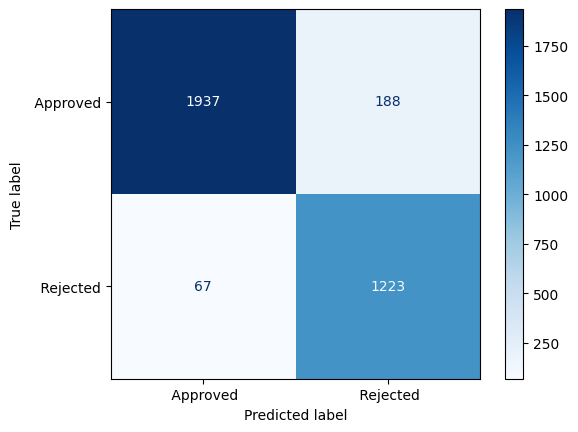

In [70]:
# Confusion Matrix - Train Set
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap='Blues')

The confusion matrix shows:

- True Positives (Rejected correctly predicted as Rejected): 1223

- True Negatives (Approved correctly predicted as Approved): 1937

- False Positives (Approved incorrectly predicted as Rejected): 188

- False Negatives (Rejected incorrectly predicted as Approved): 67

This indicates that model performs well at identifying both approved and rejected loans. Also this model showing low false positive and false negative counts suggests a good overall balance.

In [71]:
# Predict on test set
y_test_pred = log_reg.predict(X_test)
y_test_proba = log_reg.predict_proba(X_test)[:, 1]  # Probability for class 1 (rejected)

# F1 Score - Test Set
print('F1 Score - Test Set   : ', f1_score(y_test, y_test_pred, average='weighted'))

# Classification Report - Test Set
print('\nClassification Report - Test Set:\n', classification_report(y_test, y_test_pred, zero_division=0))

# ROC AUC - Test Set
roc_score_test = roc_auc_score(y_test, y_test_proba)
print(f'\nROC AUC Score - Test Set: {roc_score_test:.4f}')

F1 Score - Test Set   :  0.929132941280732

Classification Report - Test Set:
               precision    recall  f1-score   support

    Approved       0.97      0.91      0.94       531
    Rejected       0.87      0.95      0.91       323

    accuracy                           0.93       854
   macro avg       0.92      0.93      0.93       854
weighted avg       0.93      0.93      0.93       854


ROC AUC Score - Test Set: 0.9711


During testing, the model achieved an overall F1-Score of 0.92. Specifically, the Approved class obtained an F1-Score of 0.94, while the Rejected class achieved 0.91, indicating balanced performance across both classes. The model also recorded a ROC AUC Score of 0.9711, demonstrating its strong ability to distinguish between approved and rejected loan applications with approximately 97.11% class separation accuracy.

The difference between training and testing performance is minimal, with the test set showing slightly higher scores. This indicates that the model generalizes well to unseen data and does not exhibit signs of overfitting, as both training and test results remain consistently strong.

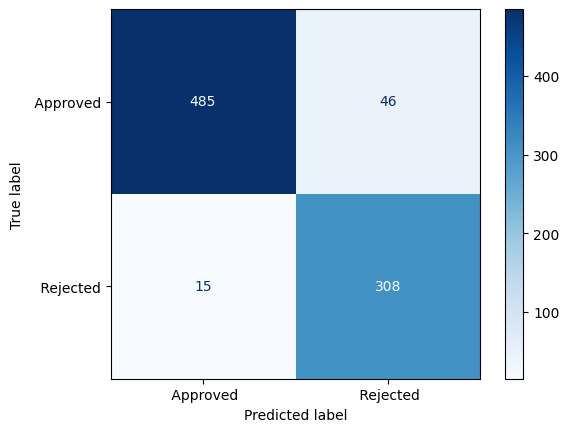

In [72]:
# Confusion Matrix - Test Set
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')

The confusion matrix shows:

- True Positives (Rejected correctly predicted as Rejected): 308

- True Negatives (Approved correctly predicted as Approved): 485

- False Positives (Approved incorrectly predicted as Rejected): 46

- False Negatives (Rejected incorrectly predicted as Approved): 15

The model accurately identified 308 rejected and approved loans. The number of FP (46) suggests some approved loans were incorrectly predicted as Rejected, which could be considered conservative from a risk perspective. With only 15 FN, meaning very few are rejected loans were mistakenly approved, which is favourable in real-world loan approval scenarios.

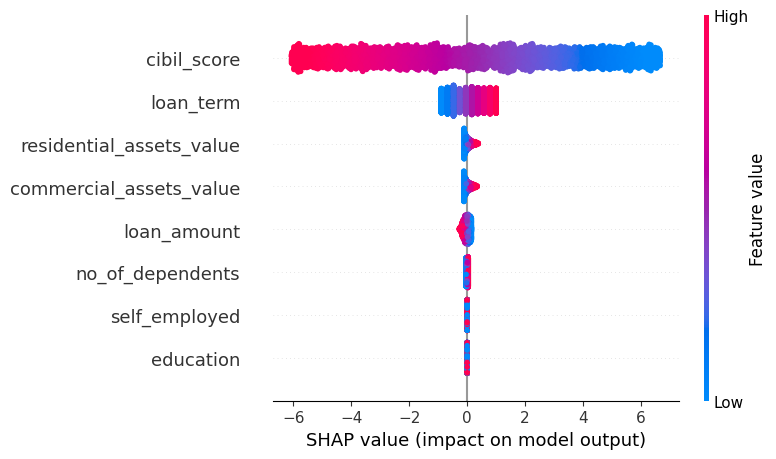

In [73]:
# Get numeric and categorical feature names after transformation
num_features = num_cols  # Your numeric columns remain unchanged after StandardScaler
cat_features = []  # To store encoded categorical features

# Extract encoded feature names for each categorical column
for col in cat_cols:
    # Assuming OrdinalEncoder encodes each category as a single column
    cat_features.append(col)

# Combine final feature names
final_feature_names = num_features + cat_features + list(pass_cols)  # If you have passthrough columns

# Transform the data
X_train_transformed = log_reg.named_steps['preprocessing'].transform(X_train)

# Convert to DataFrame for SHAP with proper column names
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=final_feature_names)

# SHAP explainer
model = log_reg.named_steps['classifier']
explainer = shap.Explainer(model, X_train_transformed_df)
shap_values = explainer(X_train_transformed_df)

# SHAP plot with real feature names
shap.summary_plot(shap_values, X_train_transformed_df)


The model heavily relies on CIBIL Score and Loan Term when making predictions. Other features contribute to a lesser degree, but collectively they still provide useful information. The clear relationship between CIBIL Score and loan approval aligns with real-world expectations, where higher creditworthiness strongly improves the chances of loan approval.

The SHAP summary plot helps us understand how each feature affects the model's loan approval predictions:

- CIBIL Score is the most important factor. Higher scores increase the chance of approval, while lower scores make rejection more likely.

- Loan Term also matters. Shorter loan terms are linked to higher approval chances, while longer terms increase the chance of rejection.

- Residential and Commercial Asset Values have some influence — generally, higher asset values help improve approval chances.

- Loan Amount, Number of Dependents, Self-Employed status, and Education have only a small impact, but they still play a role in the final prediction.

In short, the model mostly follows common sense. People with higher credit scores, shorter loan terms, and more assets are more likely to get approved.

In [74]:
joblib.dump(log_reg, 'log_reg.pkl')

['log_reg.pkl']

In [75]:
# load pipeline
log_reg = joblib.load('log_reg.pkl')

In [76]:
data_inf = {
    'no_of_dependents': 2,
    'education': 'Graduate',
    'self_employed': 'No',
    'loan_amount': 500000,
    'loan_term': 12,
    'cibil_score': 700,
    'residential_assets_value': 1000000,
    'commercial_assets_value': 500000
}

data_inf = pd.DataFrame([data_inf])
data_inf

,no_of_dependents,education,self_employed,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value
0,2,Graduate,No,500000,12,700,1000000,500000


In [77]:
y_proba_inf = log_reg.predict_proba(data_inf)[:, 1]  # Probability for class 1 (rejected)
y_pred_inf = log_reg.predict(data_inf)

# Output
print('Probability: ', y_proba_inf)
print('Prediction: ', y_pred_inf)

Probability:  [0.03965421]
Prediction:  [' Approved']


# Conclusion

The Logistic Regression model performed well, showing consistent F1-Scores and ROC AUC on both training and test sets. The model handles class imbalance effectively and key features like CIBIL Score behave as expected.

Room for improvement:

There’s still potential to improve by trying more advanced models, tuning hyperparameters, or enhancing feature engineering. But overall, this serves as a solid baseline for loan approval prediction.